In [142]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

In [143]:
# data source: 
# TODO: function to read csv
# put csv in "__init__ main" to execute
def load_flu_file(file):
    flu_df = pd.read_csv(file, header = 2)
    return flu_df

In [144]:
# data source: https://trends.google.com/trends/explore?date=2019-01-01%202020-10-27&geo=US&q=mask
# TODO: function to analyze mask google trend
# read and clean
def load_mask_file(file):
    new_header = ['Date', 'mask_interested_in_percentage']
    mask_df = pd.read_csv(file, header = 1, names = new_header)
    return mask_df

In [145]:
# data source: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
# TODO: function to analyze covid case
# read and clean

covid = pd.read_excel('COVID-19-worldwide.xlsx')
covid
# covid.groupby(["year", "month"]).sum()["cases"]

# 變成dataframe然後取出個國家的確認數&日期
# 看要不要group by年、月

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,2020-11-23,23,11,2020,252,8,Afghanistan,AF,AFG,38041757.0,Asia,6.655844
1,2020-11-22,22,11,2020,154,12,Afghanistan,AF,AFG,38041757.0,Asia,6.203709
2,2020-11-21,21,11,2020,232,25,Afghanistan,AF,AFG,38041757.0,Asia,6.130106
3,2020-11-20,20,11,2020,282,5,Afghanistan,AF,AFG,38041757.0,Asia,5.672714
4,2020-11-19,19,11,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,5.036571
...,...,...,...,...,...,...,...,...,...,...,...,...
57422,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57423,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57424,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57425,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN


In [146]:
def get_covid_cases(country_name: str):
    if country_name == "US":
        country_name = "United_States_of_America"
    elif country_name == "UK" or country_name == "UK1516" or country_name == "UK1718":
        country_name = "United_Kingdom"
    country = covid.loc[covid["countriesAndTerritories"] == country_name]
    # country_new = country.groupby(["year", "month"]).sum()["cases"]
    # print(df)
    country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))
    country_new = country.groupby(["yearmonth"]).sum()["cases"]
    return country_new

In [147]:
# columns we want: year, month, ALL_INF, mask google trend
# TODO: function to make a separte column of datetime
# and then group by 1. year and 2. month (2 conditions)   ('ALL_INF')



In [148]:
def get_total_flu_case_by_month(file):
    file["yearmonth"] = pd.to_datetime(file["EDATE"]).map(lambda dt: dt.replace(day=1))
    file_new = file.groupby(["yearmonth"]).sum()["ALL_INF"]
    return file_new

In [149]:
def get_mask_search_trend_by_month(file):
    file["yearmonth"] = pd.to_datetime(file["Date"]).map(lambda dt: dt.replace(day=1))
    file_new = file.groupby(["yearmonth"]).mean()["mask_interested_in_percentage"]
    return file_new

In [150]:
# aggregrate everything by country
# columns: year, month, mask, flu, covid
def aggregrate_data(flu_data, mask_data, covid_cases, country_name: str):
    merge = pd.concat([flu_data, mask_data, covid_cases], axis = 1).reset_index()
    merge["year"] = merge["yearmonth"].dt.year
    merge["month"] = merge["yearmonth"].dt.month
    if country_name == "UK1516" or country_name == "UK1718":
        country_name == "UK"
    merge["country"] = country_name
    merge = merge[["year", "month", "yearmonth", "country", "ALL_INF", "mask_interested_in_percentage", "cases"]]
    merge = merge.rename(columns = {"ALL_INF": "flu cases"})
    return merge

In [151]:
def extract_info(country: str):
    flu = "FluNetInteractiveReport_" + country + ".csv"
    
    if country == "UK1516" or country == "UK1718":
        country = "UK"
    mask = "multiTimeline_" + country + ".csv"
    
    fludata = load_flu_file(flu)
    mask_trend = load_mask_file(mask)
    fludata_new = get_total_flu_case_by_month(fludata)
    mask_trend_new = get_mask_search_trend_by_month(mask_trend)
    covid_case = get_covid_cases(country)
    result_data = aggregrate_data(fludata_new, mask_trend_new, covid_case, country)
    return result_data
    

In [152]:
def separate_data(data, year: int) -> pd.DataFrame:
    data_new = data.loc[data["year"] == year]
    return data_new

In [167]:
# Data visualization
# import matplotlib as plt
def plot_graph(country: pd.DataFrame, year: int):
    plot_data = separate_data(country, year) # extract data from specific year
    flucase=plot_data['flu cases']
    mask_trend = plot_data["mask_interested_in_percentage"]
    fig, ax1 = plt.subplots()
    plt.title(country["country"][0] + str(year))
    plt.xlabel('month')
    ax2 = ax1.twinx()
    
    
    time=plot_data['month']
    ax1.set_ylabel('num. of cases', color='black')
    ax1.plot(time, flucase, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2.set_ylabel('mask trend', color='orange')
    ax2.set_yticks(range(1, 101, 10))
    ax2.plot(time, mask_trend, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim([1,100])
    
    fig.tight_layout() # i'm not sure the purpose of this line
    
    #DATE = []
    #for y, m in zip(plot_data.year, plot_data.month):
    #    DATE.append(date(y, m,1))
    #plot_data['DATE'] = DATE
    
    #plt.plot(time, flucase)
    #plt.plot(time, mask_trend)
    #plt.xlabel('month')
    #plt.ylabel('num. of cases')
    plt.show()

    
    
#plt.title('Numbers of blocks NN opened per Game')
#plt.xlabel('Game')
#ax2 = ax1.twinx()

In [228]:
def plot_graph3(country: pd.DataFrame):
    plot_data15 = separate_data(country, 2015)
    plot_data16 = separate_data(country, 2016)
    plot_data17 = separate_data(country, 2017)
    plot_data18 = separate_data(country, 2018)
    plot_data19 = separate_data(country, 2019)
    plot_data20 = separate_data(country, 2020)
    # extract data from specific year
    flucase15=plot_data15['flu cases']
    flucase16=plot_data16['flu cases']
    flucase17=plot_data17['flu cases']
    flucase18=plot_data18['flu cases']
    flucase19=plot_data19['flu cases']
    flucase20=plot_data20['flu cases']
    fig, ax1 = plt.subplots()
    plt.title('The num. of flu cases in '+country["country"][0]+' in 2015-2020')
    plt.xlabel('month')


    time=plot_data15['month']
    time20=plot_data20['month']
    ax1.set_ylabel('num. of cases', color='black')
    #ax1.tick_params(axis='y', labelcolor='black')
    plt.plot(time, flucase15, color='black',label='2015')
    plt.plot(time, flucase16, color='grey',label='2016')
    plt.plot(time, flucase17, color='navy',label='2017')
    plt.plot(time, flucase18, color='tan',label='2018')
    plt.plot(time, flucase19, color='silver',label='2019')
    plt.plot(time20, flucase20, color='red',label='2020')
    fig.tight_layout()

In [154]:
# if __name__ == "__main__":
# files
"""
flu_china = 'FluNetInteractiveReport_China.csv'
flu_usa = 'FluNetInteractiveReport_US.csv'
flu_uk = 'FluNetInteractiveReport_UK.csv'
mask_china = 'multiTimeline_China.csv'
mask_usa = 'multiTimeline_US.csv'
mask_uk = 'multiTimeline_UK.csv'
"""

china = extract_info("China")
us = extract_info("US")
uk1516 = extract_info("UK1516")
uk1718 = extract_info("UK1718")
uk1920 = extract_info("UK")

# load data
# fludata_china = load_flu_file(flu_china)
# mask_trend_china = load_mask_file(mask_china)
# clean data
# fludata_china_new = get_total_flu_case_by_month(fludata_china)
# mask_trend_china_new = get_mask_search_trend_by_month(mask_trend_china)
# covid_case = get_covid_cases("China")
# merga all data together
# result_data = aggregrate_data(fludata_china_new, mask_trend_china_new, covid_case, "China")
us

<ipython-input-146-d5aaf865ab91>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))


,year,month,yearmonth,country,flu cases,mask_interested_in_percentage,cases
0,2015,1,2015-01-01,US,37272.0,NaN,NaN
1,2015,2,2015-02-01,US,20066.0,NaN,NaN
2,2015,3,2015-03-01,US,12169.0,NaN,NaN
3,2015,4,2015-04-01,US,5037.0,NaN,NaN
4,2015,5,2015-05-01,US,2054.0,NaN,NaN
...,...,...,...,...,...,...,...
66,2020,7,2020-07-01,US,61.0,53.50,1904462.0
67,2020,8,2020-08-01,US,62.0,33.80,1502149.0
68,2020,9,2020-09-01,US,85.0,27.00,1193898.0
69,2020,10,2020-10-01,US,39.0,27.25,1856366.0


In [180]:
separate_data(us, 2020)

,year,month,yearmonth,country,flu cases,mask_interested_in_percentage,cases
60,2020,1,2020-01-01,US,75582.0,11.25,6.0
61,2020,2,2020-02-01,US,96058.0,16.75,60.0
62,2020,3,2020-03-01,US,55735.0,41.40,164554.0
63,2020,4,2020-04-01,US,700.0,70.75,875289.0
64,2020,5,2020-05-01,US,194.0,42.80,730475.0
65,2020,6,2020-06-01,US,84.0,42.75,820168.0
66,2020,7,2020-07-01,US,61.0,53.50,1904462.0
67,2020,8,2020-08-01,US,62.0,33.80,1502149.0
68,2020,9,2020-09-01,US,85.0,27.00,1193898.0
69,2020,10,2020-10-01,US,39.0,27.25,1856366.0


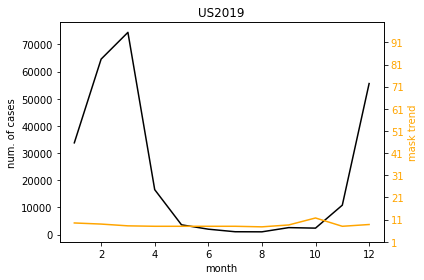

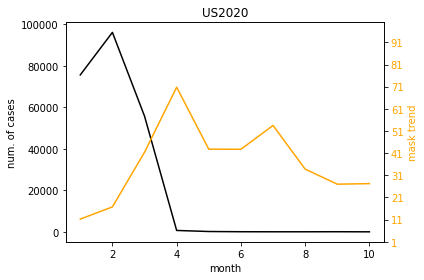

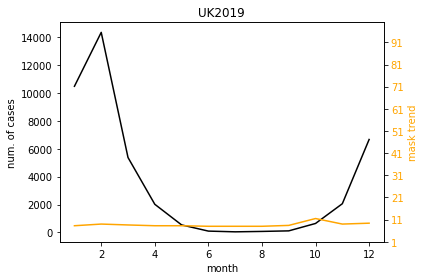

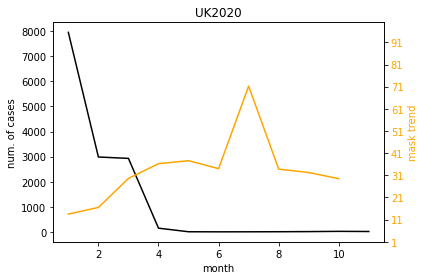

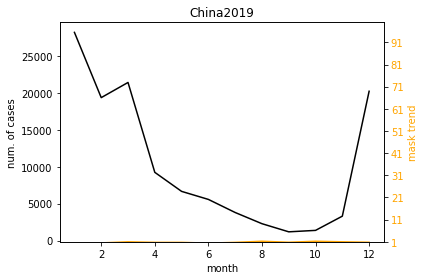

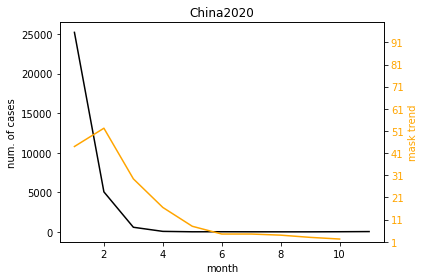

In [156]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
us_graph2019=plot_graph(us, 2019)
us_graph2020=plot_graph(us, 2020)

uk_graph2019=plot_graph(uk1920, 2019)
uk_graph2020=plot_graph(uk1920, 2020)

china_graph2019=plot_graph(china, 2019)
china_graph2020=plot_graph(china, 2020)

# flu應該和溫度變化比較有相關，不管口罩搜尋量有沒有增加，flu到夏天時都會好轉。
# However,注意到2019-12和2020-12，因為2020有covid，所以流感沒有回升

In [157]:
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)

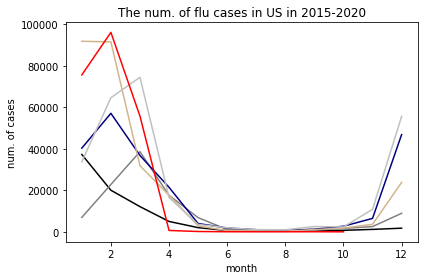

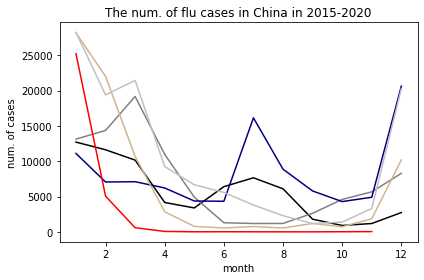

In [229]:
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1 x 3)(2015~2020)
us_graph=plot_graph3(us)
china_graph=plot_graph3(china)
#uk_graph=plot_graph3(uk)